In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [32]:
# Step 1: LIBRARIES LOADING FUNCTION
import numpy as np
from numpy import mean, std
from matplotlib import pyplot as plt
import seaborn as sns
from keras.datasets import fashion_mnist


In [33]:
# Step 2: LOAD DATA FUNCTION-Loading the Raw Dataset
def load_data():
    return fashion_mnist.load_data()


In [34]:
# Step 3: SPLIT DATA FUNCTION-Dataset Splitting into Cross-Validation and Test Datasets
def split_data(X_test, y_test):
    # Split the X_test/y_test dataset into cross-val & test datasets
    # Randomly sort X_test/y_test
    indexes = np.arange(X_test.shape[0])
    for _ in range(5): indexes = np.random.permutation(indexes)  # shuffle 5 times!
    X_test = X_test[indexes]
    y_test = y_test[indexes]

    # Split into cross-val & test sets (use 8000 records in cross-val set;80%:20% Ratio)
    val_count = 8000
    X_val = X_test[:val_count]
    y_val = y_test[:val_count]
    X_test = X_test[val_count:]
    y_test = y_test[val_count:]

    # Keep a non-preprocessed copy of X_test/y_test for visualization
    test_images, test_labels = X_test.copy(), y_test.copy()

    return X_val, y_val, X_test, y_test, test_images, test_labels


In [35]:
# Step 4: SCALE IMAGES FUNCTION-Scaling the Images
def scale_images(X_train, X_val, X_test):
    # Scale the images to between 0-1
    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    return X_train, X_val, X_test


In [36]:
# Step 5: RESHAPE IMAGES FUNCTION-Reshaping the Images into 3D Tensors
def reshape_images(X_train, X_val, X_test):
    # Reshape the images into 3D tensors so our CNN can use it
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

    return X_train, X_val, X_test


In [37]:
# Step 6: LOADING & PREPROCESSING DATA FUNCTION
def load_and_preprocess_data(debug=False):
    # Load the raw dataset
    (X_train, y_train), (X_test, y_test) = load_data()

    # Split test set into cross-validation and test sets
    X_val, y_val, X_test, y_test, test_images, test_labels = split_data(X_test, y_test)

    # Scale the images
    X_train, X_val, X_test = scale_images(X_train, X_val, X_test)

    # Reshape the images
    X_train, X_val, X_test = reshape_images(X_train, X_val, X_test)

    # Create TensorFlow datasets for training, validation, and test
    batch_size = 32  # Define your batch size
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    if debug:
        print('After preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
        print(' - test_images.shape = {}, test_labels.shape = {}'.format(test_images.shape, test_labels.shape))

    return (train_dataset, val_dataset, test_dataset), (test_images, test_labels)


In [38]:
# Step 7: DEFINE DICTIONARY FOR FASHION LABELS
FASHION_LABELS = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}


In [39]:
# Step 8: SETUP SEABORN STYLING
sns.set_context("notebook", font_scale=1.1)
sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})


In [40]:
# Step 9: DEFINE DISPLAY SAMPLE FUNCTION
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10,
                   plot_title=None, fig_size=None):
    """ Display a random selection of images and corresponding labels """
    assert sample_images.shape[0] == num_rows * num_cols

    # Create subplots grid
    f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 9) if fig_size is None else fig_size),
                         gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

    # Loop through rows and columns to plot the images and labels
    for r in range(num_rows):
        for c in range(num_cols):
            image_index = r * num_cols + c
            ax[r, c].axis("off")
            ax[r, c].imshow(sample_images[image_index], cmap="Greys")  # Show selected image

            # Handle predictions and actual labels
            if sample_predictions is None:
                title = ax[r, c].set_title("%s" % FASHION_LABELS[sample_labels[image_index]])
            else:
                true_label = sample_labels[image_index]
                pred_label = sample_predictions[image_index]
                prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])

                if prediction_matches_true:
                    title = FASHION_LABELS[true_label]
                    title_color = 'g'
                else:
                    title = '%s/%s' % (FASHION_LABELS[true_label], FASHION_LABELS[pred_label])
                    title_color = 'r'

                plt.setp(title, color=title_color)

    # Set plot title, if one is specified
    if plot_title is not None:
        f.suptitle(plot_title)

    plt.show()
    plt.close()


In [41]:
# Step 10: LOAD DATA AND DISPLAY SAMPLES
(train_dataset, val_dataset, test_dataset), (test_images, test_labels) = load_and_preprocess_data(debug=True)

After preprocessing:
 - X_train.shape = (60000, 28, 28, 1), y_train.shape = (60000,)
 - X_val.shape = (8000, 28, 28, 1), y_val.shape = (8000,)
 - X_test.shape = (2000, 28, 28, 1), y_test.shape = (2000,)
 - test_images.shape = (2000, 28, 28), test_labels.shape = (2000,)


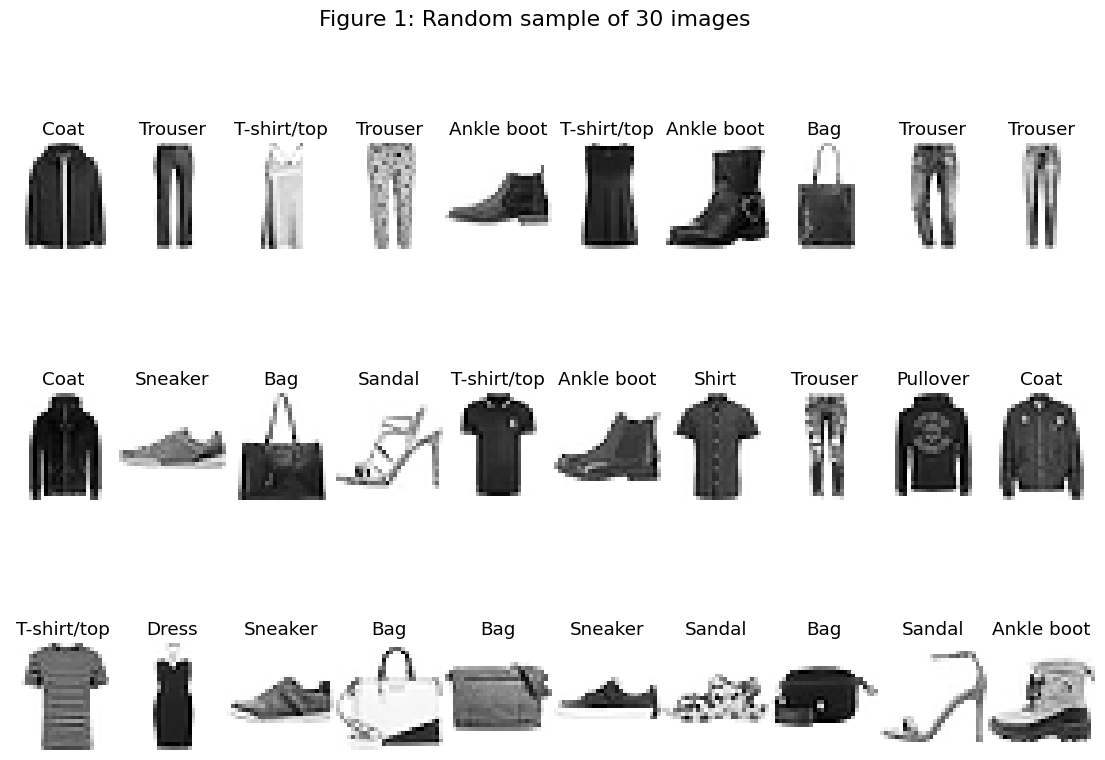

In [42]:
# Step 11: SAMPLE IMAGES AND DISPLAY THEM
sample_size = 30
rand_indexes = np.random.randint(0, len(test_images), sample_size)  # Use test_images length
sample_images = test_images[rand_indexes]
sample_labels = test_labels[rand_indexes]

# Adjusting number of rows and columns for display_sample
num_rows = 3
num_cols = 10

display_sample(sample_images, sample_labels,
               num_rows=num_rows, num_cols=num_cols,
               plot_title='Figure 1: Random sample of %d images' % sample_size)


In [13]:
# Step 1: Keras imports
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [14]:
# Step 2: Define image dimensions and classes
Image_Height, Image_Width, Num_Channels, Num_Classes = 28, 28, 1, 10


In [15]:
# Step 3: Build the model
def build_model():
    """
    Builds a Keras CNN model for Fashion MNIST classification.
    """
    K.clear_session()  # Clear any previous sessions

    model = Sequential([
        Input(shape=(Image_Height, Image_Width, Num_Channels)),  # Add Input layer

        # First block of Conv2D, BatchNorm, and MaxPooling
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Second block of Conv2D, BatchNorm, and MaxPooling
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Third block of Conv2D, BatchNorm, and MaxPooling
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Flatten for the Dense layers
        Flatten(),

        # Fully connected Dense layers with Dropout for regularization
        Dense(1024, activation='relu'),
        Dropout(0.5),  # Add dropout to reduce overfitting
        Dense(512, activation='relu'),
        Dropout(0.5),  # Add dropout

        # Output layer
        Dense(Num_Classes, activation='softmax')  # Final layer with softmax for classification
    ])

    return model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 13, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,940,938 (7.40 MB)

 Trainable params: 1,939,146 (7.40 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 793s 420ms/step - accuracy: 0.7772 - loss: 0.6453 - val_accuracy: 0.8796 - val_loss: 0.3434
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 798s 418ms/step - accuracy: 0.8928 - loss: 0.3161 - val_accuracy: 0.8997 - val_loss: 0.2912
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 783s 417ms/step - accuracy: 0.9074 - loss: 0.2698 - val_accuracy: 0.8986 - val_loss: 0.2665
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 785s 419ms/step - accuracy: 0.9170 - loss: 0.2368 - val_accuracy: 0.9103 - val_loss: 0.2672
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 778s 415ms/step - accuracy: 0.9276 - loss: 0.2115 - val_accuracy: 0.9068 - val_loss: 0.2696
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 784s 418ms/step - accuracy: 0.9365 - loss: 0.1836 - val_accuracy: 0.9199 - val_loss: 0.2435
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 800s 417ms/step - accuracy: 0.9430 - loss: 0.1617 - val_accuracy: 0.9235 - val_loss: 0.2388
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 802s 417ms/step - ac

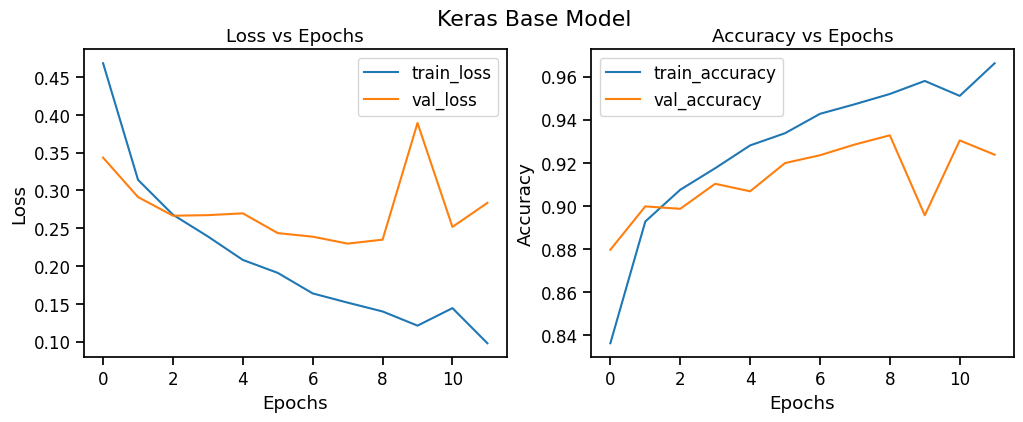


Evaluating...
Training data:
  Training : loss 0.09 - acc 0.97
Cross-validation data:
  Cross-val: loss 0.23 - acc 0.93
Test data:
  Testing  : loss 0.24 - acc 0.93
Saving model...


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=kr_fashion_cnn_base.

In [16]:
# Step 1: Import the Adam Optimizer
from tensorflow.keras.optimizers import Adam

# Step 2: Ensure mixed precision is enabled
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Step 3: Define the train and evaluate the model
def train_and_evaluate_model(model, train_dataset, val_dataset, test_dataset,
                             plot_title=None,
                             callbacks=None, model_save_name=None,
                             num_epochs=25):
    """
    Cross-train & evaluate the model's performance on training, cross-validation & test datasets.

    @steps:
        - model: the Keras model to be trained
        - pre-processing the training, cross-validation, and the testing datasets
        - display the training history plots
        - evaluate metrics (This project uses the default values for batch size=32 & num_epochs=25)
        - build and compile the model
        - display the model architecture
        - define the model name and plot title
        - train and evaluate the model
        - save the Keras model
    """

    # Step 4: Train on train_dataset & cross-validate on val_dataset
    history = model.fit(train_dataset, epochs=num_epochs,
                        validation_data=val_dataset,
                        callbacks=callbacks)

    # Step 5: Display training history plots
    if plot_title is not None:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='train_loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.title('Loss vs Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='train_accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.title('Accuracy vs Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.suptitle(plot_title)
        plt.show()

    # Step 6: Evaluate metrics
    print("\nEvaluating...", flush=True)

    print('Training data:', flush=True)
    loss, acc = model.evaluate(train_dataset, verbose=0)  # Set verbose to 0 for less output
    print("  Training : loss %.2f - acc %.2f" % (loss, acc))

    print('Cross-validation data:', flush=True)
    loss, acc = model.evaluate(val_dataset, verbose=0)
    print("  Cross-val: loss %.2f - acc %.2f" % (loss, acc))

    print('Test data:', flush=True)
    loss, acc = model.evaluate(test_dataset, verbose=0)
    print("  Testing  : loss %.2f - acc %.2f" % (loss, acc))

    if model_save_name is not None:
        print('Saving model...', flush=True)
        model.save(model_save_name)  # Save the model directly


from tensorflow.keras.callbacks import EarlyStopping # Early stopping when no significant validation accuracies are detected for 3 consecutive epochs

# Step 7: Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)


# Step 8: Build and compile the model
model = build_model()  # Create the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])  # Compile the model

# Step 9: Display the model architecture
model.summary()  # Show the model architecture

# Step 10: Define model name and plot title
model_name_base = 'kr_fashion_cnn_base'
plot_title_base = 'Keras Base Model'

# Step 11: Train and evaluate the model
train_and_evaluate_model(model, train_dataset, val_dataset, test_dataset,
                         plot_title=plot_title_base, model_save_name=model_name_base,
                         callbacks=[early_stopping])  # Pass the early_stopping callback here

# Step 12: Optionally, delete the model if no longer needed
# del model(REMOVE THE #, & CLICK ENTER)


###### NB: The saving error mentioned above has been addressed in the code below. Re-training the model would be time-consuming, even with a reduced number of epochs set to 12, where the process automatically stops.

#### SAVING THE MODEL TO GOOGLE DRIVE

In [22]:

# Step 1: Mount Google Drive to save the model persistently
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Corrected save file path (saving to Google Drive)
model_name_base = '/content/drive/MyDrive/kr_fashion_cnn_base.keras'  # Use the `.keras` extension

# Step 3: Save the model
model.save(model_name_base)  # Save in Keras format

print(f"Model saved as {model_name_base}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved as /content/drive/MyDrive/kr_fashion_cnn_base.keras


#### PREDICTIONS: PERFORMANCE EVALUATION ON TEST DATASET

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Evaluating against test data...
  - Test data: loss 0.59 - acc 0.78
Displaying sample predictions...
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


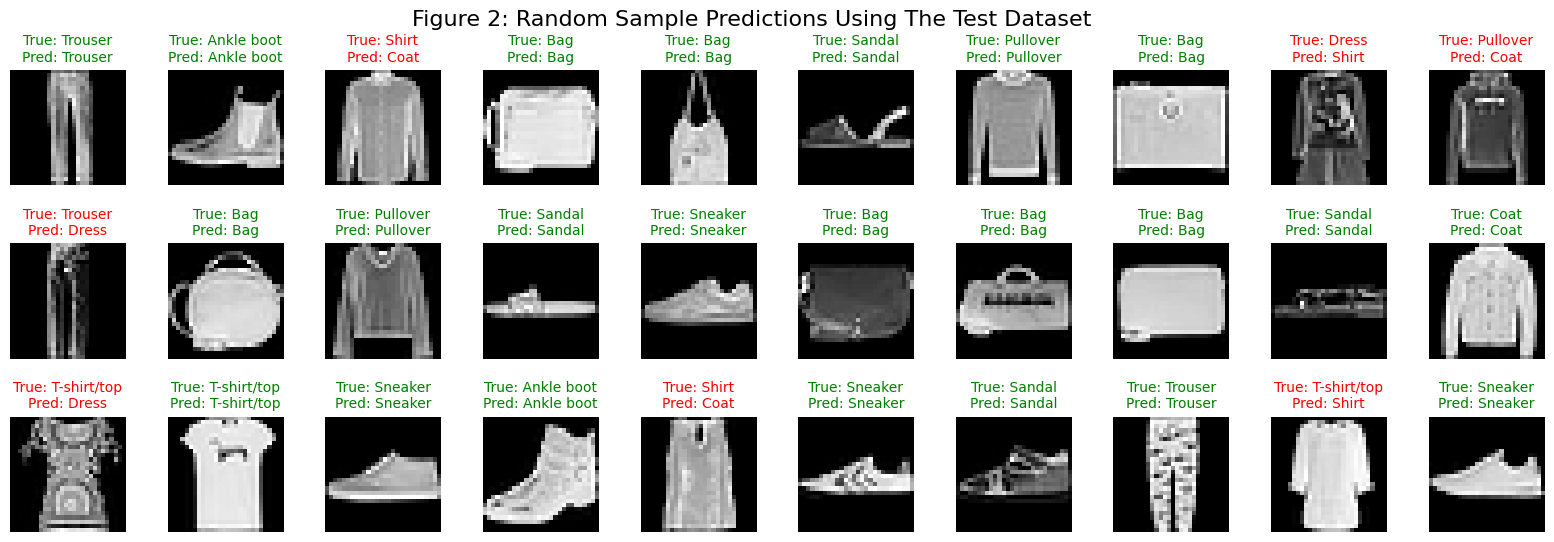

313/313 ━━━━━━━━━━━━━━━━━━━━


In [43]:
import numpy as np
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt

# Step 1: Mount Google Drive to save the model persistently
drive.mount('/content/drive')

# Step 2: Define the function to display sample predictions
def display_sample(sample_images, sample_labels, sample_predictions, num_rows, num_cols, plot_title=None):
    """ Display images with corresponding true and predicted labels """
    plt.figure(figsize=(num_cols * 2, num_rows * 2))
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')  # Ensure correct reshape for 28x28 images

        # Determine the color based on whether the prediction matches the true label
        if sample_labels[i] == sample_predictions[i]:
            color = 'green'  # Correct prediction
        else:
            color = 'red'    # Incorrect prediction

        plt.title(f"True: {FASHION_LABELS[sample_labels[i]]}\nPred: {FASHION_LABELS[sample_predictions[i]]}", fontsize=10, color=color)
        plt.axis('off')
    plt.subplots_adjust(hspace=0.5)  # Increase space between rows
    plt.suptitle(plot_title, fontsize=16)
    plt.show()

# Step 3: Define the function to do predictions
def do_predictions(model_save_name, X_test, y_test, test_images, test_labels, plot_title=None):
    def test_model(model, X_test, y_test, test_images, test_labels, plot_title=None):
        print('Evaluating against test data...', flush=True)

        # Get the total number of samples
        num_samples = X_test.shape[0]
        batch_size = 32  # Your defined batch size

        # Calculate total number of batches
        total_batches = np.ceil(num_samples / batch_size).astype(int)

        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print('  - Test data: loss %.2f - acc %.2f' % (loss, acc))

        print('Displaying sample predictions...', flush=True)
        # Run predictions
        y_pred = model.predict(X_test)

        # Test with 30 random images
        sample_size = 30
        rand_indexes = np.random.randint(0, len(X_test), sample_size)
        sample_images = test_images[rand_indexes]
        sample_labels = test_labels[rand_indexes]
        sample_predictions = np.argmax(y_pred[rand_indexes], axis=1)

        # Adjusting number of rows and columns for display_sample
        num_rows = 3
        num_cols = 10

        display_sample(sample_images, sample_labels, sample_predictions,
                       num_rows=num_rows, num_cols=num_cols,
                       plot_title=plot_title)

        # Print the number of batches processed
        print(f'{total_batches}/{total_batches} ━━━━━━━━━━━━━━━━━━━━')

    # Load the model from the saved state
    model = tf.keras.models.load_model(model_save_name)  # Load model from Google Drive
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Use sparse_categorical_crossentropy for integer labels
    test_model(model, X_test, y_test, test_images, test_labels, plot_title=plot_title)
    del model  # Delete the model to free up memory

# Step 4: Load and preprocess data
def load_and_preprocess_data():
    # Load the raw dataset
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    # Simulate a split to create test images and labels
    test_images, test_labels = X_test, y_test  # In a real scenario, you may want to further split or preprocess

    # Scale the images
    X_test = X_test.astype('float32') / 255.0  # Scale to [0, 1]

    # Reshape the images into 3D tensors for CNN (28x28x1)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

    return X_test, y_test, test_images, test_labels

# Step 5: Call the function to load data
X_test, y_test, test_images, test_labels = load_and_preprocess_data()

# Step 6: Call the function to do predictions
do_predictions('/content/drive/MyDrive/kr_fashion_cnn_base.keras', X_test, y_test, test_images, test_labels, plot_title="Figure 2: Random Sample Predictions Using The Test Dataset")
